# Eda - Matheus Miranda Brandão

## Importando as bibliotecas necessárias

In [1]:

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("crest", as_cmap=True)
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

from tqdm import tqdm
tqdm.pandas(desc="my bar!")

## Tables

Carregando o banco de dados, já tratado anteriormente

In [2]:
df = pd.read_pickle('../../datasets/processed/movies.pkl')
df.head()

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin
0,Avatar: The Way of Water,8.0,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",New Zealand,350000000.0,681081686.0,United States
1,Guillermo del Toro's Pinocchio,7.8,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Bu...","Animation, Drama, Family",USA,35000000.0,71614.0,"United States, Mexico, France"
2,Bullet Train,7.3,2022,August,R,127,David Leitch,"Brad Pitt, Joey King, Aaron Taylor Johnson, Br...","Action, Comedy, Thriller",Japan,85900000.0,239268602.0,"Japan, United States"
3,The Banshees of Inisherin,8.0,2022,November,R,114,Martin McDonagh,"Colin Farrell, Brendan Gleeson, Kerry Condon, ...","Comedy, Drama",Ireland,40000000.0,19720823.0,"Ireland, United Kingdom, United States"
4,M3gan,6.7,2022,January,PG-13,102,Gerard Johnstone,"Jenna Davis, Amie Donald, Allison Williams, Vi...","Horror, Sci-Fi, Thriller",New Zealand,40000000.0,90776006.5,United States


In [3]:
def classification_of_runtime(x: int) -> str:
    if x < 60:
        return 'short'
    elif x < 120:
        return 'medium'
    elif x < 180:
        return 'long'
    else:
        return 'eternity'

df['time_classification'] = df.runtime.progress_apply(classification_of_runtime)
del classification_of_runtime

my bar!: 100%|██████████| 2000/2000 [00:00<00:00, 1261634.53it/s]


In [4]:
df['profit'] = df.income - df.budget
df['proportional_profit'] = np.round(df.income/df.budget*100, 2)

In [5]:
def classification_of_profit(x: int) -> str:
    if x < 0:
        return 'failure'
    else:
        return 'gain'

df['profit_classification'] = df.profit.progress_apply(classification_of_profit)

my bar!: 100%|██████████| 2000/2000 [00:00<00:00, 1144421.28it/s]


In [6]:
df.profit_classification.value_counts()

gain       1551
failure     449
Name: profit_classification, dtype: int64

Observando como os dados numericos se comportam.

In [7]:
df.describe()

,rating,year,runtime,budget,income,profit,proportional_profit
count,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,6.667650,2012.500000,113.214500,5.794723e+07,1.807404e+08,1.227932e+08,4.780803e+05
std,0.912576,5.767723,19.598075,5.644956e+07,2.645420e+08,2.265593e+08,2.031075e+07
min,1.900000,2003.000000,50.000000,1.000000e+01,3.050000e+02,-2.092240e+08,0.000000e+00
25%,6.175000,2007.750000,99.000000,2.000000e+07,2.931354e+07,3.547832e+06,1.161575e+02
50%,6.700000,2012.500000,110.000000,4.000000e+07,9.077601e+07,5.077601e+07,2.376800e+02
75%,7.300000,2017.250000,124.000000,7.500000e+07,2.081357e+08,1.427683e+08,4.353575e+02
max,9.600000,2022.000000,242.000000,3.560000e+08,2.922918e+09,2.685918e+09,9.077601e+08


Observando os dados categóricos.

In [8]:
df.describe(exclude=['float64', 'uint16', 'uint32', 'uint8'])

,title,month,certificate,directors,stars,genre,filming_location,country_of_origin,time_classification,profit_classification
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,1989,12,11,1082,1990,244,97,406,4,2
top,The Hunt,November,R,Ridley Scott,"Jennifer Lawrence, Josh Hutcherson, Liam Hemsw...","Action, Adventure, Sci-Fi",USA,United States,medium,gain
freq,2,262,901,13,2,92,906,942,1357,1551


### Observando um pouco os valores pertencentes as colunas de strings

In [9]:
def list_of_str(array: np.ndarray) -> pd.DataFrame:
    new_df = pd.Series(np.sum((array) + ',').split(',')).str.strip()
    test = new_df.copy()
    new_df = pd.DataFrame(list(set(new_df)), columns=[array.name])
    new_df.drop(index=new_df[new_df[array.name] == ''].index, inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    new_df['frequency'] = [test.str.fullmatch(item).sum() for item in tqdm(new_df[array.name].values)]
    
    return new_df

In [10]:
list_of_directors = list_of_str(df.directors)

100%|██████████| 1151/1151 [00:00<00:00, 1343.03it/s]


In [11]:
list_of_directors.sort_values('frequency', ascending=False).head(10)

,directors,frequency
163,Ridley Scott,13
382,Steven Spielberg,12
1016,Antoine Fuqua,11
50,Shawn Levy,10
7,Michael Bay,10
273,Clint Eastwood,10
202,Quentin Tarantino,9
748,Joel Coen,9
1130,Tim Burton,9
977,Robert Rodriguez,9


In [12]:
list_of_directors.sort_values('frequency', ascending=True).head(10)

,directors,frequency
0,Rob Bowman,1
663,Patrik Forsberg,1
664,Stephen Daldry,1
667,Peter Howitt,1
668,James Ward Byrkit,1
669,Eli Craig,1
671,Joe Dante,1
673,Asger Leth,1
675,Doug Ellin,1
680,Ash Brannon,1


In [13]:
list_of_stars = list_of_str(df.stars)

100%|██████████| 3502/3502 [00:08<00:00, 391.16it/s]


In [14]:
list_of_stars.sort_values('frequency', ascending=False).head(10)

,stars,frequency
1020,Dwayne Johnson,25
2700,Mark Wahlberg,24
2145,Ryan Reynolds,23
1855,Scarlett Johansson,22
1573,Matt Damon,22
2292,Brad Pitt,22
2418,Amy Adams,22
2912,Liam Neeson,21
2105,Tom Hanks,21
1242,Cate Blanchett,21


In [15]:
list_of_stars.sort_values('frequency', ascending=True).head(10)

,stars,frequency
0,Sophia Lillis,1
2081,Joe Alwyn,1
2082,Caoilinn Springall,1
2084,Tasha de Vasconcelos,1
2087,Gene Hackman,1
2088,David Corenswet,1
2089,Philip Boyd,1
2090,Natalie Krill,1
2092,Edward Ashley,1
2095,Karam Taher,1


In [16]:
list_of_genres = list_of_str(df.genre)

100%|██████████| 20/20 [00:00<00:00, 528.63it/s]


In [17]:
list_of_genres.sort_values('frequency', ascending=False).head(10)

,genre,frequency
18,Drama,968
7,Comedy,682
8,Action,656
10,Adventure,523
13,Thriller,363
2,Crime,332
14,Romance,283
6,Horror,262
5,Mystery,228
11,Sci-Fi,213


In [18]:
list_of_genres.sort_values('frequency', ascending=True).head(10)

,genre,frequency
19,Western,11
4,Musical,20
16,War,22
3,Sport,32
15,Music,44
0,History,57
12,Animation,118
1,Family,125
17,Biography,139
9,Fantasy,202


In [19]:
list_of_country_origin = list_of_str(df.country_of_origin)

100%|██████████| 63/63 [00:00<00:00, 774.13it/s]


In [20]:
list_of_country_origin.sort_values('frequency', ascending=False).head(10)

,country_of_origin,frequency
21,United States,1784
31,United Kingdom,452
52,Canada,217
4,France,181
37,Germany,177
2,China,101
50,Japan,77
40,Australia,68
43,Spain,48
15,Italy,41


In [21]:
list_of_country_origin.sort_values('frequency', ascending=True).head(10)

,country_of_origin,frequency
0,Qatar,1
27,Slovenia,1
20,Bahamas,1
39,Cyprus,1
53,Paraguay,1
14,Saudi Arabia,1
56,Portugal,1
47,Iran,1
11,Philippines,1
12,Serbia,1


### Agrupando algumas colunas

In [22]:
df.groupby('time_classification').agg({
    'rating': ['mean', 'median']
})

rating       
                         mean median
time_classification                 
eternity             7.850000   7.85
long                 7.091587   7.10
medium               6.459027   6.50
short                8.500000   8.50

Ao agrupar por ano vemos a média, mediana e somatório.

In [23]:
df.groupby('year').agg({
    'rating': ['mean', 'median', 'sum'], 
    'runtime': ['mean', 'median', 'sum'],
    'income': ['mean', 'median', 'sum']
})

rating               runtime                      income                \
       mean median    sum    mean median    sum          mean        median   
year                                                                          
2003  6.579   6.70  657.9  110.79  108.0  11079  1.483425e+08  9.051777e+07   
2004  6.746   6.80  674.6  111.03  106.0  11103  1.565439e+08  1.028244e+08   
2005  6.565   6.70  656.5  111.15  109.0  11115  1.414480e+08  8.900840e+07   
2006  6.713   6.75  671.3  112.87  108.0  11287  1.444764e+08  8.569510e+07   
2007  6.756   6.95  675.6  112.12  109.5  11212  1.620166e+08  9.077601e+07   
2008  6.596   6.70  659.6  107.73  106.0  10773  1.783801e+08  1.122377e+08   
2009  6.679   6.75  667.9  111.85  107.0  11185  1.872593e+08  9.080933e+07   
2010  6.691   6.60  669.1  108.69  107.0  10869  1.875894e+08  9.395458e+07   
2011  6.754   6.80  675.4  110.60  107.5  11060  1.977062e+08  1.300719e+08   
2012  6.675   6.75  667.5  112.58  109.0  11258  2.266304e+08  1.215538e+08   
2013  6.734   6.75  673.4  113.67  112.0  11367  2.132888e+08  9.872105e+07   
2014  6.692   6.60  669.2  113.05  109.0  11305  2.213606e+08  1.248981e+08   
2015  6.688   6.75  668.8  116.02  117.0  11602  2.273229e+08  9.137342e+07   
2016  6.762   6.85  676.2  114.25  114.5  11425  2.209106e+08  1.193104e+08   
2017  6.714   6.70  671.4  115.10  115.0  11510  2.276579e+08  9.077601e+07   
2018  6.677   6.75  667.7  117.24  118.0  11724  2.363394e+08  9.077601e+07   
2019  6.691   6.75  669.1  117.37  117.0  11737  2.339085e+08  9.077601e+07   
2020  6.326   6.50  632.6  107.80  105.5  10780  6.910270e+07  4.858000e+07   
2021  6.612   6.60  661.2  118.09  114.5  11809  1.161049e+08  4.077206e+07   
2022  6.703   6.70  670.3  122.29  118.5  12229  1.184192e+08  9.077601e+07   

                    
               sum  
year                
2003  1.483425e+10  
2004  1.565439e+10  
2005  1.414480e+10  
2006  1.444764e+10  
2007  1.620166e+10  
2008  1.783801e+10  
2009  1.872593e+10  
2010  1.875894e+10  
2011  1.977062e+10  
2012  2.266304e+10  
2013  2.132888e+10  
2014  2.213606e+10  
2015  2.273229e+10  
2016  2.209106e+10  
2017  2.276579e+10  
2018  2.363394e+10  
2019  2.339085e+10  
2020  6.910270e+09  
2021  1.161049e+10  
2022  1.184192e+10

Observando a moda dos dados categóricos por ano

In [24]:
df.groupby('year')[
    [
        'month', 'certificate', 
        'directors', 'filming_location', 
        'budget', 'country_of_origin'
    ]
].agg(lambda x: x.mode()[0])

,month,certificate,directors,filming_location,budget,country_of_origin
year,,,,,,
2003,November,R,"Lana Wachowski, Lilly Wachowski",USA,40000000.0,United States
2004,July,R,Garry Marshall,USA,30000000.0,United States
2005,December,PG-13,Catherine Hardwicke,USA,40000000.0,United States
2006,November,R,Shawn Levy,USA,40000000.0,United States
2007,November,R,Richard LaGravenese,USA,40000000.0,United States
2008,December,PG-13,Clint Eastwood,USA,20000000.0,United States
2009,December,R,Christian Alvart,USA,40000000.0,United States
2010,June,R,Adam Green,USA,40000000.0,United States
2011,August,R,Steven Spielberg,USA,40000000.0,United States


Proporção de classificação indicativa nos filmes.

In [25]:
pd.DataFrame(zip(
    df.certificate.value_counts(), 
    df.certificate.value_counts(normalize=True)
    ), index=df.certificate.value_counts().index, columns=['count', 'percentage'])

,count,percentage
R,901,0.4505
PG-13,714,0.3570
PG,225,0.1125
Unrated,67,0.0335
TV-MA,40,0.0200
G,22,0.0110
TV-14,12,0.0060
TV-PG,9,0.0045
NC-17,6,0.0030
TV-G,3,0.0015


Proporção de locação nos filmes

In [26]:
pd.DataFrame(zip(
    df.filming_location.value_counts(), 
    df.filming_location.value_counts(normalize=True)
    ), index=df.filming_location.value_counts().index, columns=['count', 'percentage'])

,count,percentage
USA,906,0.4530
Canada,209,0.1045
UK,177,0.0885
Unknown,76,0.0380
Australia,44,0.0220
...,...,...
Guam,1,0.0005
Gabon,1,0.0005
French Polynesia,1,0.0005
Rwanda,1,0.0005


In [27]:
pd.DataFrame(zip(
    df.country_of_origin.value_counts(), 
    df.country_of_origin.value_counts(normalize=True)
    ), index=df.country_of_origin.value_counts().index, columns=['count', 'percentage'])

,count,percentage
United States,942,0.4710
"United Kingdom, United States",95,0.0475
"United States, United Kingdom",74,0.0370
"United States, Canada",73,0.0365
United Kingdom,34,0.0170
...,...,...
"United States, France, Hong Kong",1,0.0005
"France, Belgium, United States",1,0.0005
"United States, China, Spain, Japan, Germany",1,0.0005
"Canada, United States, United Kingdom",1,0.0005


Proporção da janela de lançamento de filmes

In [28]:
pd.DataFrame(zip(
    df.month.value_counts(), 
    df.month.value_counts(normalize=True)
    ), index=df.month.value_counts().index, columns=['count', 'percentage'])

,count,percentage
November,262,0.1310
December,248,0.1240
October,187,0.0935
June,166,0.0830
July,152,0.0760
September,151,0.0755
March,150,0.0750
August,149,0.0745
January,149,0.0745
May,144,0.0720


Observando os valores max e min

In [29]:
df.query('profit == @df.profit.min() | profit == @df.profit.max()')

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin,time_classification,profit,proportional_profit,profit_classification
123,Zack Snyder's Justice League,8.0,2021,March,R,242,Zack Snyder,"Henry Cavill, Ben Affleck, Gal Gadot, Amy Adams","Action, Adventure, Fantasy",Iceland,300000000.0,9.077601e+07,United States,eternity,-2.092240e+08,30.26,failure
1300,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",USA,237000000.0,2.922918e+09,United States,long,2.685918e+09,1233.30,gain


In [30]:
df.query('proportional_profit == @df.proportional_profit.min() | proportional_profit == @df.proportional_profit.max()')

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin,time_classification,profit,proportional_profit,profit_classification
11,Babylon,7.7,2022,December,R,188,Damien Chazelle,"Brad Pitt, Margot Robbie, Jean Smart, Olivia W...","Comedy, Drama, History",USA,78000000.0,1470.0,United States,eternity,-77998530.0,0.0,failure
101,Farha,8.4,2021,December,TV-14,92,Darin J Sallam,"Karam Taher, Ashraf Barhom, Ali Suliman, Tala ...",Drama,Jordan,40000000.0,703.0,"Jordan, Saudi Arabia, Sweden",medium,-39999297.0,0.0,failure
396,"Yes, God, Yes",6.1,2019,July,R,78,Karen Maine,"Natalia Dyer, Timothy Simons, Wolfgang Novogra...","Comedy, Drama",Unknown,40000000.0,305.0,United States,medium,-39999695.0,0.0,failure
1176,Now & Later,5.1,2011,February,Unrated,99,Philippe Diaz,"Keller Wortham, Shari Solanis, Luis Fernandez ...",Drama,USA,40000000.0,1808.0,United States,medium,-39998192.0,0.0,failure
1203,A Serbian Film,5.0,2010,June,NC-17,104,Srdjan Spasojevic,"Srdjan Zika Todorovic, Sergej Trifunovic, Jele...","Horror, Mystery, Thriller",Serbia,40000000.0,1541.0,Serbia,medium,-39998459.0,0.0,failure
1249,My Little Princess,9.6,2010,September,R,110,Enzo Zelocchi,"Enzo Zelocchi, Charlotte Labadie, David M Edel...","Romance, Drama, Family",Unknown,10.0,90776006.5,United States,medium,90775996.5,907760065.0,gain


Ordenando em relação ao lucro bruto e dps relativo.

In [31]:
df.sort_values('profit', ascending=False).head(10)

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin,time_classification,profit,proportional_profit,profit_classification
1300,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",USA,237000000.0,2.922918e+09,United States,long,2.685918e+09,1233.30,gain
305,Avengers: Endgame,8.4,2019,April,PG-13,181,"Anthony Russo, Joe Russo","Robert Downey Jr , Chris Evans, Mark Ruffalo, ...","Action, Adventure, Drama",UK,356000000.0,2.797501e+09,United States,eternity,2.441501e+09,785.81,gain
714,Star Wars: Episode VII - The Force Awakens,7.8,2015,December,PG-13,138,J J Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...","Action, Adventure, Sci-Fi",Ireland,245000000.0,2.069522e+09,United States,long,1.824522e+09,844.70,gain
405,Avengers: Infinity War,8.4,2018,April,PG-13,149,"Anthony Russo, Joe Russo","Robert Downey Jr , Chris Hemsworth, Mark Ruffa...","Action, Adventure, Sci-Fi",UK,321000000.0,2.048360e+09,United States,long,1.727360e+09,638.12,gain
103,Spider-Man: No Way Home,8.3,2021,December,PG-13,148,Jon Watts,"Tom Holland, Zendaya, Benedict Cumberbatch, Ja...","Action, Adventure, Fantasy",Iceland,200000000.0,1.917430e+09,United States,long,1.717430e+09,958.72,gain
723,Jurassic World,6.9,2015,June,PG-13,124,Colin Trevorrow,"Chris Pratt, Bryce Dallas Howard, Ty Simpkins,...","Action, Adventure, Sci-Fi",USA,150000000.0,1.671537e+09,United States,long,1.521537e+09,1114.36,gain
344,The Lion King,6.8,2019,July,PG,118,Jon Favreau,"Donald Glover, Beyonc , Seth Rogen, Chiwetel E...","Animation, Adventure, Drama",South Africa,260000000.0,1.663250e+09,"United States, United Kingdom",medium,1.403250e+09,639.71,gain
753,Furious 7,7.1,2015,April,PG-13,137,James Wan,"Vin Diesel, Paul Walker, Dwayne Johnson, Jason...","Action, Crime, Thriller",United Arab Emirates,190000000.0,1.515341e+09,"United States, China, Japan, Canada, United Ar...",long,1.325341e+09,797.55,gain
27,Top Gun: Maverick,8.4,2022,May,PG-13,130,Joseph Kosinski,"Tom Cruise, Jennifer Connelly, Miles Teller, V...","Action, Drama",USA,170000000.0,1.488733e+09,United States,long,1.318733e+09,875.73,gain
335,Frozen II,6.8,2019,November,PG,103,"Chris Buck, Jennifer Lee","Kristen Bell, Idina Menzel, Josh Gad, Jonathan...","Animation, Adventure, Comedy",USA,150000000.0,1.450027e+09,United States,medium,1.300027e+09,966.68,gain


In [32]:
df.sort_values('proportional_profit', ascending=False).head(10)

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin,time_classification,profit,proportional_profit,profit_classification
1249,My Little Princess,9.6,2010,September,R,110,Enzo Zelocchi,"Enzo Zelocchi, Charlotte Labadie, David M Edel...","Romance, Drama, Family",Unknown,10.000000,90776006.5,United States,medium,9.077600e+07,9.077601e+08,gain
995,Banshee,8.5,2013,September,R,50,Gemma Mc Carthy,"Jonathan O Dwyer, Sean Flood, Frank Hurley, Fi...",Action,Ireland,320.777310,90776006.5,Ireland,short,9.077569e+07,2.829876e+07,gain
487,Trautmann,7.2,2018,October,R,120,Marcus H Rosenm ller,"David Kross, Freya Mavor, John Henshaw, Harry ...","Biography, Drama, Romance",Northern Ireland,11.761835,1916514.0,"United Kingdom, Germany",long,1.916502e+06,1.629435e+07,gain
1557,Paranormal Activity,6.3,2007,October,R,86,Oren Peli,"Katie Featherston, Micah Sloat, Mark Fredrichs...","Horror, Mystery",USA,15000.000000,193355800.0,United States,medium,1.933408e+08,1.289039e+06,gain
477,The VelociPastor,5.0,2018,August,Unrated,75,Brendan Steere,"Greg Cohan, George Schewnzer, Janice Young, Da...","Action, Adventure, Comedy",USA,11000.000000,90776006.5,"United States, China",medium,9.076501e+07,8.252364e+05,gain
94,Skinamarink,5.4,2022,January,R,100,Kyle Edward Ball,"Jaime Hill, Lucas Paul, Ross Paul, Dali Rose T...",Horror,Canada,15000.000000,90776006.5,Canada,medium,9.076101e+07,6.051734e+05,gain
578,Picture of Beauty,3.4,2017,April,R,70,Maxim Ford,"Taylor Sands, Danielle Rose, Pawel Hajnos, Mag...","Drama, Romance",Poland,119870.000000,90776006.5,United Kingdom,medium,9.065614e+07,7.572871e+04,gain
1549,The Man from Earth,7.9,2007,November,Unrated,87,Richard Schenkman,"David Lee Smith, Tony Todd, John Billingsley, ...","Drama, Fantasy, Mystery",USA,200000.000000,90776006.5,United States,medium,9.057601e+07,4.538800e+04,gain
791,Circle,6.0,2015,October,Unrated,87,"Aaron Hann, Mario Miscione","Allegra Masters, Aimee McKay, Ashley Key, Autu...","Drama, Horror, Mystery",Unknown,250000.000000,90776006.5,United States,medium,9.052601e+07,3.631040e+04,gain
848,Mantus,2.1,2014,November,R,110,Enzo Zelocchi,"Enzo Zelocchi, Miryam Negrin, Paul Gregory, Ma...","Comedy, Drama, Thriller",USA,250000.000000,90776006.5,United States,medium,9.052601e+07,3.631040e+04,gain


In [33]:
df.sort_values('rating', ascending=False).head(10)

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin,time_classification,profit,proportional_profit,profit_classification
1249,My Little Princess,9.6,2010,September,R,110,Enzo Zelocchi,"Enzo Zelocchi, Charlotte Labadie, David M Edel...","Romance, Drama, Family",Unknown,1.000000e+01,9.077601e+07,United States,medium,9.077600e+07,9.077601e+08,gain
1401,The Dark Knight,9.0,2008,July,PG-13,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","Action, Crime, Drama",USA,1.850000e+08,1.006234e+09,"United States, United Kingdom",long,8.212342e+08,5.439100e+02,gain
1193,"67th Street, New York, NY",9.0,2011,January,R,105,Enzo Zelocchi,"Enzo Zelocchi, David Man, Ladae Bond, Casey Cadag","Crime, Thriller",Unknown,3.000000e+05,9.077601e+07,United States,medium,9.047601e+07,3.025867e+04,gain
1903,The Lord of the Rings: The Return of the King,9.0,2003,December,PG-13,201,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...","Action, Adventure, Drama",New Zealand,9.400000e+07,1.146458e+09,"New Zealand, United States",eternity,1.052458e+09,1.219640e+03,gain
1200,Inception,8.8,2010,July,PG-13,148,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon Levitt, Ellio...","Action, Adventure, Sci-Fi",Canada,1.600000e+08,8.368481e+08,"United States, United Kingdom",long,6.768481e+08,5.230300e+02,gain
800,Interstellar,8.6,2014,November,PG-13,169,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...","Adventure, Drama, Sci-Fi",Iceland,1.650000e+08,7.738672e+08,"United States, United Kingdom, Canada",long,6.088672e+08,4.690100e+02,gain
84,Drishyam 2,8.6,2022,November,R,140,Abhishek Pathak,"Ajay Devgn, Tabu, Akshaye Khanna, Shriya Saran","Crime, Drama, Mystery",India,4.000000e+07,2.776721e+06,India,long,-3.722328e+07,6.940000e+00,failure
1607,The Prestige,8.5,2006,October,PG-13,130,Christopher Nolan,"Christian Bale, Hugh Jackman, Scarlett Johanss...","Drama, Mystery, Sci-Fi",USA,4.000000e+07,1.096763e+08,"United Kingdom, United States",long,6.967631e+07,2.741900e+02,gain
995,Banshee,8.5,2013,September,R,50,Gemma Mc Carthy,"Jonathan O Dwyer, Sean Flood, Frank Hurley, Fi...",Action,Ireland,3.207773e+02,9.077601e+07,Ireland,short,9.077569e+07,2.829876e+07,gain
1604,The Departed,8.5,2006,October,R,151,Martin Scorsese,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...","Crime, Drama, Thriller",USA,9.000000e+07,2.914805e+08,"United States, Hong Kong",long,2.014805e+08,3.238700e+02,gain


In [34]:
df.sort_values('rating', ascending=True).head(10)

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin,time_classification,profit,proportional_profit,profit_classification
1484,Disaster Movie,1.9,2008,August,PG-13,87,"Jason Friedberg, Aaron Seltzer","Carmen Electra, Vanessa Lachey, Nicole Parker,...","Comedy, Sci-Fi",USA,20000000.0,34816824.0,United States,medium,14816824.0,174.08,gain
848,Mantus,2.1,2014,November,R,110,Enzo Zelocchi,"Enzo Zelocchi, Miryam Negrin, Paul Gregory, Ma...","Comedy, Drama, Thriller",USA,250000.0,90776006.5,United States,medium,90526006.5,36310.40,gain
1780,Son of the Mask,2.2,2005,February,PG,94,Lawrence Guterman,"Jamie Kennedy, Traylor Howard, Alan Cumming, L...","Comedy, Family, Fantasy",Australia,84000000.0,59981548.0,"United States, Germany",medium,-24018452.0,71.41,failure
1524,Epic Movie,2.4,2007,January,PG-13,86,"Jason Friedberg, Aaron Seltzer","Kal Penn, Jennifer Coolidge, Fred Willard, Ada...","Adventure, Comedy, Fantasy",USA,20000000.0,87238158.0,United States,medium,67238158.0,436.19,gain
1369,Dragonball Evolution,2.6,2009,April,PG,85,James Wong,"Justin Chatwin, James Marsters, Chow Yun Fat, ...","Action, Adventure, Fantasy",Mexico,30000000.0,55720772.0,"United Kingdom, Mexico, Hong Kong, United States",medium,25720772.0,185.74,gain
331,Cats,2.8,2019,December,PG,110,Tom Hooper,"James Corden, Judi Dench, Jason Derulo, Idris ...","Comedy, Drama, Family",UK,95000000.0,75558925.0,"United Kingdom, United States, Canada, Austral...",medium,-19441075.0,79.54,failure
1491,Meet the Spartans,2.8,2008,January,PG-13,87,"Jason Friedberg, Aaron Seltzer","Sean Maguire, Kevin Sorbo, Carmen Electra, Ken...","Comedy, Fantasy",USA,30000000.0,85897593.0,United States,medium,55897593.0,286.33,gain
200,365 Days,3.3,2020,June,TV-MA,114,"Barbara Bialowas, Tomasz Mandes","Anna Maria Sieklucka, Michele Morrone, Bronisl...","Drama, Romance",Poland,40000000.0,9458590.0,Poland,medium,-30541410.0,23.65,failure
1891,Catwoman,3.4,2004,July,PG-13,104,Pitof,"Halle Berry, Sharon Stone, Benjamin Bratt, Lam...","Action, Crime, Fantasy",USA,100000000.0,82102379.0,United States,medium,-17897621.0,82.10,failure
578,Picture of Beauty,3.4,2017,April,R,70,Maxim Ford,"Taylor Sands, Danielle Rose, Pawel Hajnos, Mag...","Drama, Romance",Poland,119870.0,90776006.5,United Kingdom,medium,90656136.5,75728.71,gain


In [35]:
pd.DataFrame(df.query('profit_classification == "failure" & rating >= 7').title.values, columns=['title'])

,title
0,Guillermo del Toro's Pinocchio
1,The Banshees of Inisherin
2,The Whale
3,The Fabelmans
4,Babylon
...,...
135,Memories of Murder
136,Tokyo Godfathers
137,A Mighty Wind
138,A Tale of Two Sisters


In [36]:
pd.DataFrame(zip(
    df.query('profit_classification == "failure"').year.value_counts(sort=False), 
    df.query('profit_classification == "failure" & rating >= 7').year.value_counts(sort=False)
    ), index=df.query('profit_classification == "failure" & rating >= 7').year.unique(), columns=['failure', 'failure_and_positive_rating'])

,failure,failure_and_positive_rating
2022,39,19
2021,49,18
2020,46,9
2019,27,9
2018,22,6
2017,23,10
2016,19,6
2015,17,5
2014,20,6
2012,12,6


## Plots (Opcional)

### Criando algumas funções para facilitar na plotagem

In [37]:
def create_bar(df_: pd, ax_: plt.axes, x_: str, y_: str, agg_: str, title_:str, rot=45):
    df = df_.groupby(by=x_, as_index=False)[y_].agg(agg_)
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    
    for value in ax_.containers:
        ax_.bar_label(value)
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [38]:
def create_box(df: pd, ax_: plt.axes, x_: str, y_: str, title_:str, rot=45):
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [39]:
def create_pie(df_: pd, ax_: plt.axes, x_: str, y_: str, title_: str, rot=45):
    df = df_.groupby(by=x_, as_index=False)[y_].count()
        
    ax_.pie(data=df, x=y_, labels=x_, autopct = "%1.2f%%", startangle = rot, colors = sns.color_palette('crest'))
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [40]:
def create_scatter(df: pd, ax_: plt.axes, x_: str, y_: str, hue_: str, title_: str):
    sns.scatterplot(data=df, x=x_, y=y_, hue=hue_, size=hue_, alpha = 0.75, ax=ax_)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

### Plotando ...

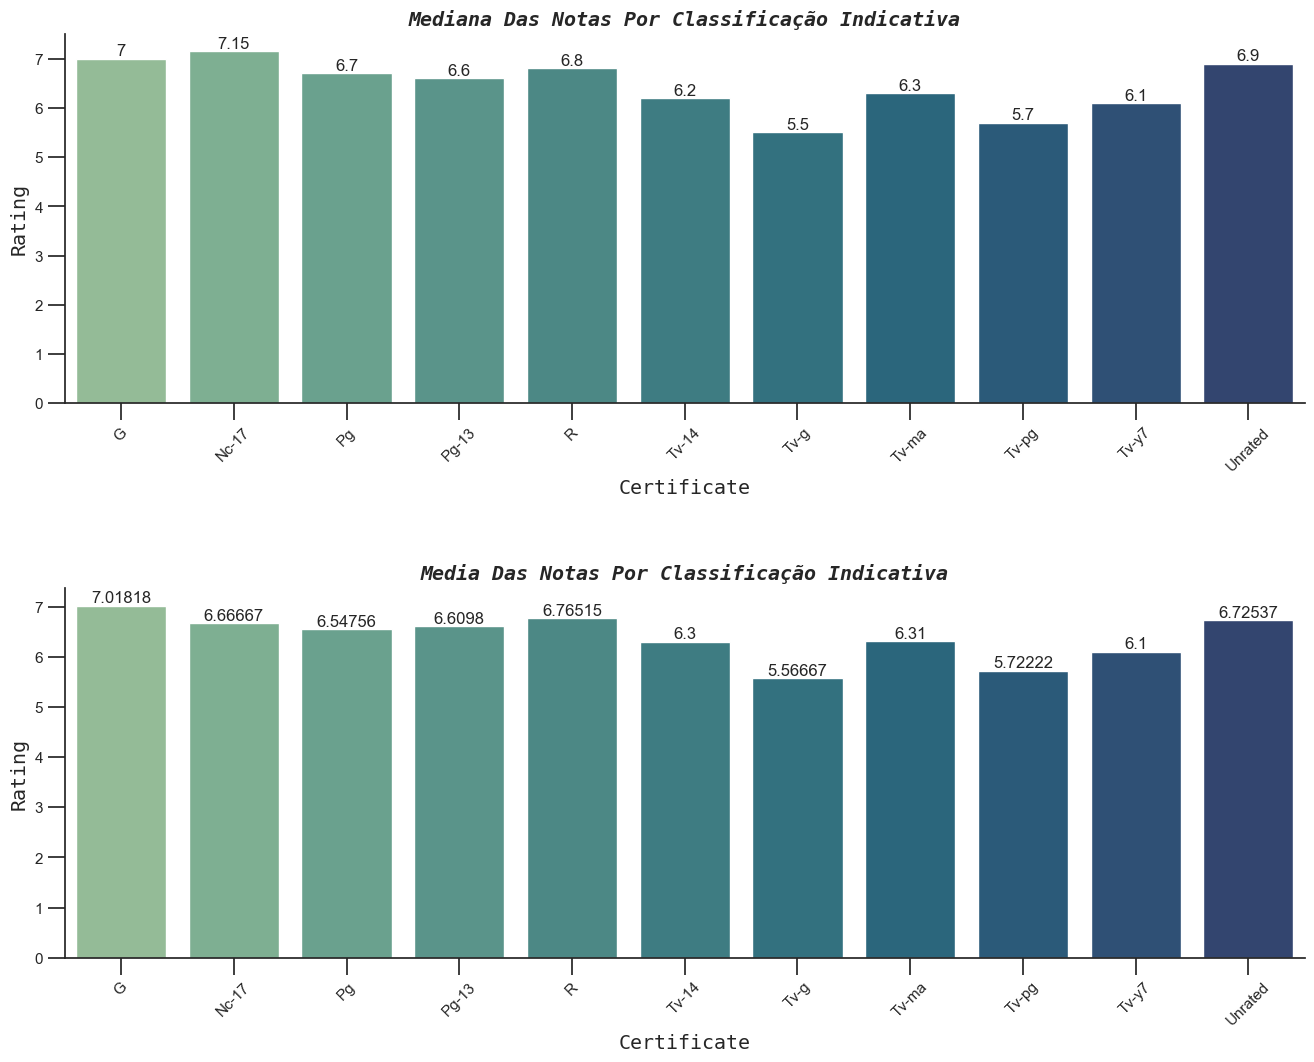

In [41]:
fig, (ax1, ax2) = plt.subplots((2), figsize=(16, 12))
create_bar(df, ax1, 'certificate', 'rating', 'median', 'Mediana das notas por classificação indicativa')
create_bar(df, ax2, 'certificate', 'rating', 'mean', 'Media das notas por classificação indicativa')
plt.subplots_adjust(hspace=.5)
plt.show()

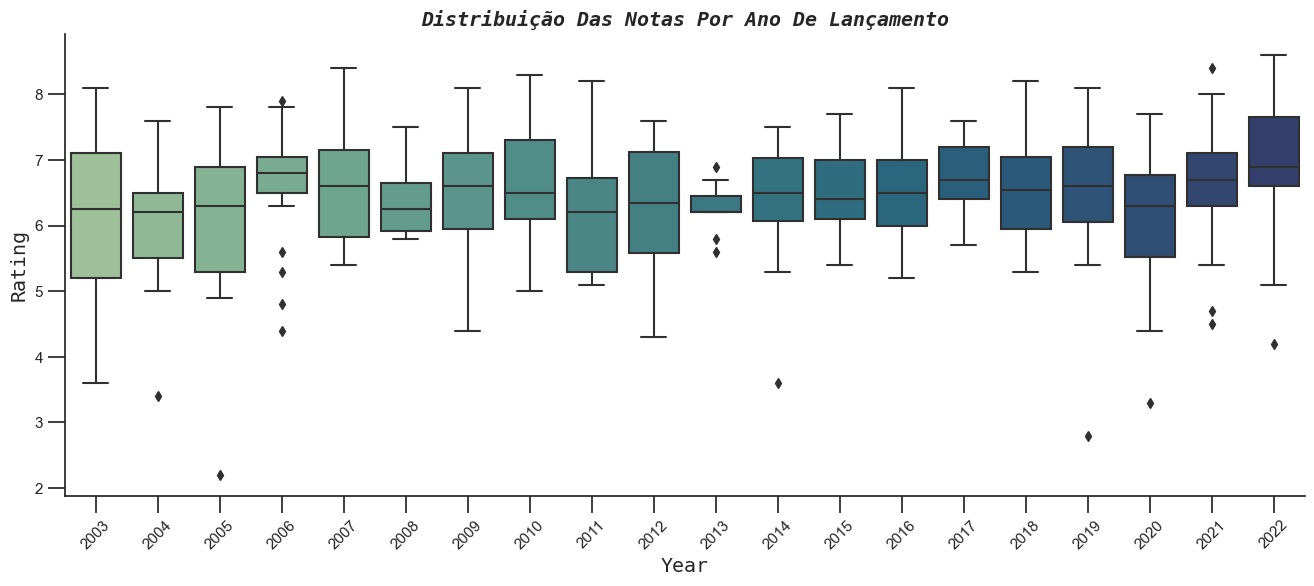

In [42]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df.query('profit_classification == "failure"'), ax, 'year', 'rating', 'Distribuição das notas por ano de lançamento')
plt.show()

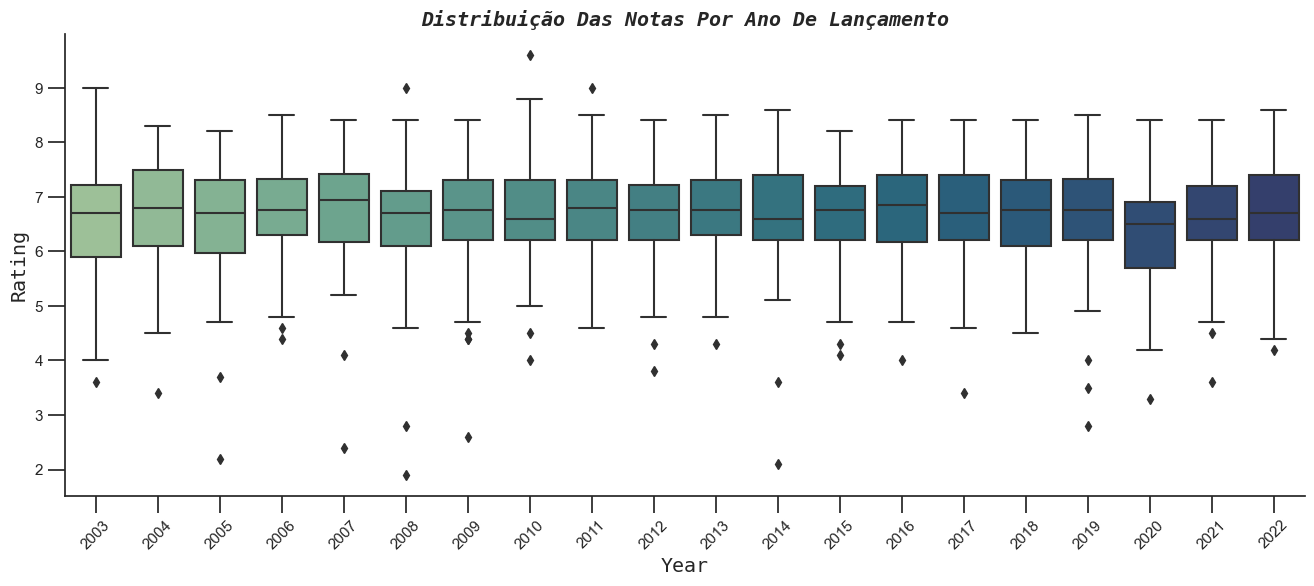

In [43]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'year', 'rating', 'Distribuição das notas por ano de lançamento')
plt.show()

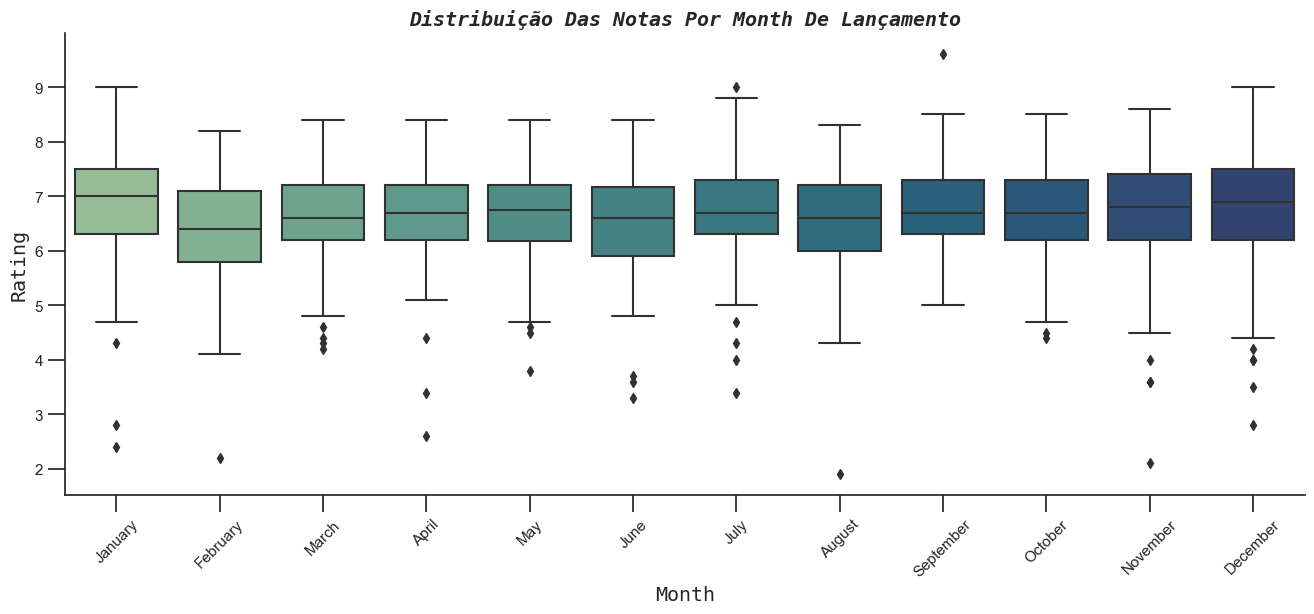

In [44]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'month', 'rating', 'Distribuição das notas por month de lançamento')
plt.show()

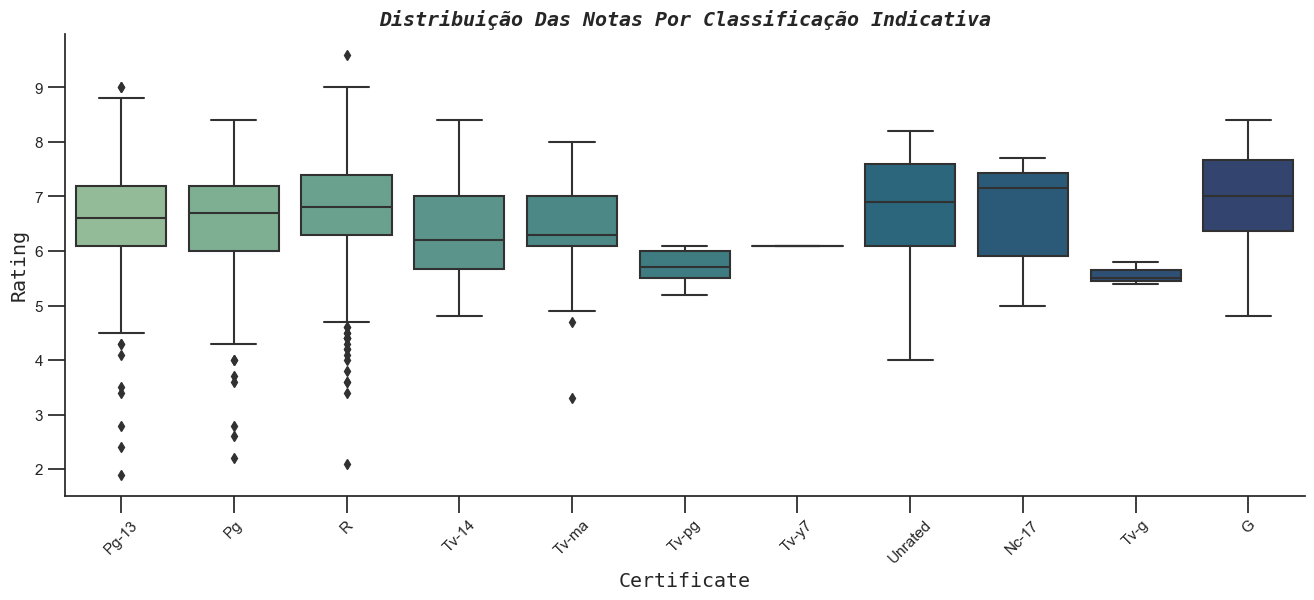

In [45]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'certificate', 'rating', 'Distribuição das notas por classificação indicativa')
plt.show()

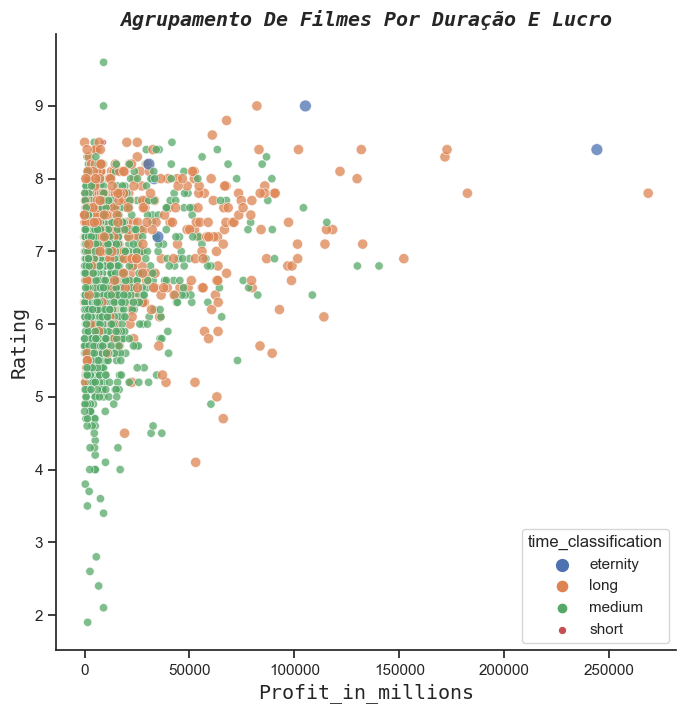

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))

df_to_scatter = df.query('profit_classification == "gain"').copy()
df_to_scatter['profit_in_millions'] = df_to_scatter.profit/10_000
create_scatter(df_to_scatter, ax, 'profit_in_millions', 'rating', 'time_classification', 'Agrupamento de filmes por duração e lucro')
del df_to_scatter

plt.show()

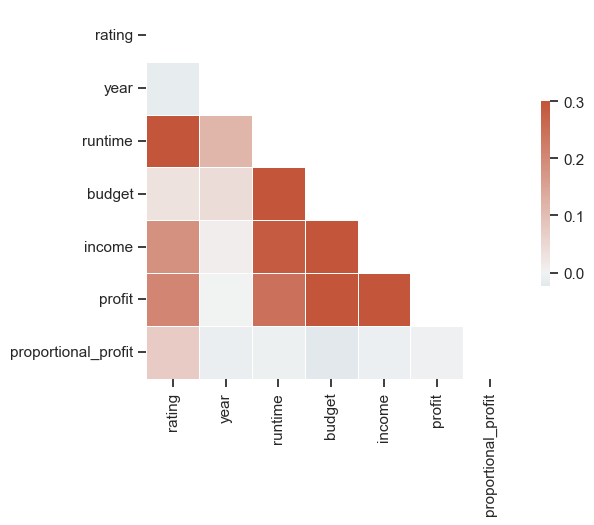

In [47]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()